In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath(os.path.join('../..', 'src')))
sys.setrecursionlimit(20500)
import pandas as pd
import spacy

import matplotlib.pyplot as plt
import clean_dataset as clean
import make_dataset as mk
import vectorize_embed as em
import tools as tools
import models as m

import pickle
import numpy as np

'''features'''
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import label_binarize

'''Classifiers'''
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.pipeline import Pipeline

'''Metrics/Evaluation'''
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
from scipy import interp
from itertools import cycle
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline

import joblib
import seaborn as sns

[nltk_data] Downloading package stopwords to C:\Users\Jonas
[nltk_data]     Nothnagel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Jonas
[nltk_data]     Nothnagel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Jonas
[nltk_data]     Nothnagel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Jonas
[nltk_data]     Nothnagel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
'''import data'''

df = pd.read_excel(os.path.abspath(os.path.join('../..', 'data/processed/encoded_labels'))+'/chemical_waste_full.xlsx')  
'''lowercase data and str type data'''
df['all_text_clean_spacy'] = df['all_text_clean_spacy'].astype(str).apply(clean.basic)
df['all_text_clean'] = df['all_text_clean'].astype(str)

(576, 10)
Index(['Unnamed: 0', 'PIMS_ID', 'all_text_clean', 'all_text_clean_spacy',
       'chemicals_and_waste_programme', 'persistent_organic_pollutants',
       'ozone_depleting_substances', 'heavy_metals', 'waste_management',
       'cooling_alternatives'],
      dtype='object')


<AxesSubplot:>

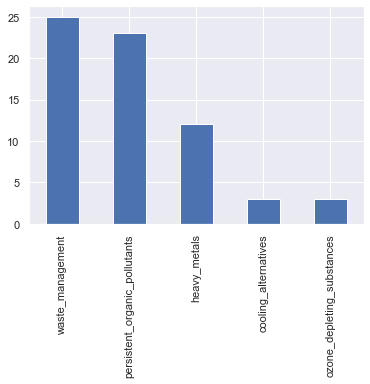

In [3]:
print(df.shape)
print(df.columns)

df[['persistent_organic_pollutants',
       'ozone_depleting_substances', 'heavy_metals', 'waste_management',
       'cooling_alternatives']].sum(axis=0).sort_values(ascending = False).plot.bar()

In [77]:
categories = ['persistent_organic_pollutants',
       'ozone_depleting_substances', 'heavy_metals', 'waste_management',
       'cooling_alternatives']

remove = []

In [79]:
# iterate over categories and save best models:
    #Creating a dict of the models
model_dict = {
              'Logistic Regression balanced' : LogisticRegression(random_state = 3, class_weight = "balanced"),
              'Logistic Regression' : LogisticRegression(random_state = 3),
              'Stochastic Gradient Descent' : SGDClassifier(random_state=3, loss='log'),
              'Stochastic Gradient Descent balanceed' : SGDClassifier(random_state=3, loss='log',class_weight = "balanced" ),
              'Random Forest': RandomForestClassifier(random_state=3),
              'Decsision Tree': DecisionTreeClassifier(random_state=3),
              'AdaBoost': AdaBoostClassifier(random_state=3),
              'Gaussian Naive Bayes': GaussianNB(),
              'K Nearest Neighbor': KNeighborsClassifier()}
    
for category in categories: 
    
    print('processing:', category)
    print('_____')
    #Creating the features (tf-idf weights) for the processed text
    texts = df_all_clean['all_text_clean'].astype('str')

    tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), 
                                       min_df = 2, 
                                       max_df = .95)
    X = tfidf_vectorizer.fit_transform(texts)     
    y = df_all_clean[category].values
    
    if len(category) > 50:
         shorter = category[0:50]
         #save vectorizer:
         filename = '../../models/tf_idf/technical_team/'+shorter+'_'+'vectorizer.sav'
         joblib.dump(tfidf_vectorizer, filename)    
        
    else:
        #save vectorizer:
        filename = '../../models/tf_idf/technical_team/'+category+'_'+'vectorizer.sav'
        joblib.dump(tfidf_vectorizer, filename)    
        
    #Dimenionality reduction. Only using the 100 best features er category
    lsa = TruncatedSVD(n_components=150, 
                   n_iter=20, 
                   random_state=3)
    X = lsa.fit_transform(X)

    if len(category) > 50:
        print('long')
        shorter = category[0:50]
        #save lsa model:
        filename = '../../models/tf_idf/technical_team/'+shorter+'_'+'lsa.sav'
        joblib.dump(lsa, filename)
    else:
        #save vectorizer:
        filename = '../../models/tf_idf/technical_team/'+category+'_'+'lsa.sav'
        joblib.dump(lsa, filename)  
    
    #Train test split with stratified sampling for evaluation
    X_train, X_test, y_train, y_test = train_test_split(X, 
                                                        y, 
                                                        test_size = .3, 
                                                        shuffle = True, 
                                                        stratify = y, 
                                                        random_state = 3)
    
    m.model_score_df(model_dict, category, 'technical_team', X_train, X_test, y_train, y_test)

processing: persistent_organic_pollutants
_____
persistent_organic_pollutants
processing: ozone_depleting_substances
_____
ozone_depleting_substances
processing: heavy_metals
_____
processing: waste_management
_____
waste_management
processing: cooling_alternatives
_____
cooling_alternatives


In [94]:
#Creating the features (tf-idf weights) for the processed text
texts = df_all_clean['all_text_clean'].astype('str')

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), 
                                   min_df = 2, 
                                   max_df = .95)

X = tfidf_vectorizer.fit_transform(texts)
   
    
y = df_all_clean['waste_management'].values

#Dimenionality reduction. Only using the 100 best features er category

lsa = TruncatedSVD(n_components=250, 
                   n_iter=20, 
                   random_state=3)

X = lsa.fit_transform(X)

#Train test split with stratified sampling for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .3, 
                                                    shuffle = True, 
                                                    stratify = y, 
                                                    random_state = 3)

In [68]:
"""change vectorizer order"""

# X_train, X_test, y_train, y_test = train_test_split(df_all_clean['all_text_clean_spacy'],
#                                                     df_all_clean['persistent_organic_pollutants'].values,
#                                                     test_size = .3,
#                                                     random_state = 1,
#                                                     shuffle = True, 
#                                                     stratify = df_all_clean['persistent_organic_pollutants'].values)

# '''extract features using tfidf vecorization:'''
# vectorizer = TfidfVectorizer(ngram_range = (1,2),min_df = 2, max_df = 0.95)

# vect = vectorizer.fit(X_train)
# X_train = vect.transform(X_train)
# X_test = vect.transform(X_test)


# lsa = TruncatedSVD(n_components=100, 
#                    n_iter=10, 
#                    random_state=3)

# lsa_vect = lsa.fit(X_train)
# X_train = lsa_vect.transform(X_train)
# X_test = lsa_vect.transform(X_test)

In [95]:
#Preliminary model evaluation using default parameters

#Creating a dict of the models
model_dict = {'Dummy' : DummyClassifier(random_state=3),
              'Logistic Regression balanced' : LogisticRegression(random_state = 3, class_weight = "balanced"),
              'Logistic Regression' : LogisticRegression(random_state = 3),
              'Stochastic Gradient Descent' : SGDClassifier(random_state=3, loss='log'),
              'Stochastic Gradient Descent balanceed' : SGDClassifier(random_state=3, loss='log',class_weight = "balanced" ),
              'Random Forest': RandomForestClassifier(random_state=3),
              'Decsision Tree': DecisionTreeClassifier(random_state=3),
              'AdaBoost': AdaBoostClassifier(random_state=3),
              'Gaussian Naive Bayes': GaussianNB(),
              'K Nearest Neighbor': KNeighborsClassifier()}


#Function to get the scores for each model in a df
def model_score_df(model_dict):   
    
    models, model_name, ac_score_list, p_score_list, r_score_list, f1_score_list = [], [], [], [], [], []
    
    for k,v in model_dict.items():   

        
        v.fit(X_train, y_train)
        
        model_name.append(k)
        models.append(v)
        
        y_pred = v.predict(X_test)
        ac_score_list.append(accuracy_score(y_test, y_pred))
        p_score_list.append(precision_score(y_test, y_pred, average='macro'))
        r_score_list.append(recall_score(y_test, y_pred, average='macro'))
        f1_score_list.append(f1_score(y_test, y_pred, average='macro'))
        model_comparison_df = pd.DataFrame([model_name, ac_score_list, p_score_list, r_score_list, f1_score_list]).T
        model_comparison_df.columns = ['model_name', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score']
        model_comparison_df = model_comparison_df.sort_values(by='f1_score', ascending=False)
        
    results = dict(zip(model_name, models))
    return model_comparison_df, results

model_df, results = model_score_df(model_dict)
model_df

C:\Users\Jonas\Anaconda3\envs\nce_1\lib\site-packages\sklearn\dummy.py:131: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  warnings.warn("The default value of strategy will change from "
C:\Users\Jonas\Anaconda3\envs\nce_1\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,model_name,accuracy_score,precision_score,recall_score,f1_score
8,Gaussian Naive Bayes,0.988235,0.925504,0.925504,0.925504
1,Logistic Regression balanced,0.982353,0.85,0.990798,0.907121
7,AdaBoost,0.982353,0.910569,0.854075,0.880028
3,Stochastic Gradient Descent,0.976471,0.851008,0.851008,0.851008
9,K Nearest Neighbor,0.970588,0.796875,0.916301,0.845201
6,Decsision Tree,0.976471,0.890909,0.782647,0.827236
4,Stochastic Gradient Descent balanceed,0.970588,0.806327,0.84794,0.825641
5,Random Forest,0.970588,0.862952,0.711218,0.765128
2,Logistic Regression,0.958824,0.479412,0.5,0.489489
0,Dummy,0.923529,0.478659,0.481595,0.480122


## No Feature Reduction

In [96]:
X_train, X_test, y_train, y_test = train_test_split(df_all_clean['all_text_clean_spacy'],
                                                    df_all_clean['waste_management'].values,
                                                    test_size = .3,
                                                    random_state = 1,
                                                    shuffle = True, 
                                                    stratify = df_all_clean['waste_management'].values)


'''extract features using tfidf vecorization:'''
vectorizer = TfidfVectorizer(ngram_range = (1,2),min_df = 2, max_df = 0.95)

vect = vectorizer.fit(X_train)
X_train = vect.transform(X_train).toarray()
X_test = vect.transform(X_test).toarray()

#X_train = X_train.toarray()
#Preliminary model evaluation using default parameters

#Creating a dict of the models
model_dict = {
              'Logistic Regression balanced' : LogisticRegression(random_state = 3, class_weight = "balanced"),
              'Logistic Regression' : LogisticRegression(random_state = 3),
              'Stochastic Gradient Descent' : SGDClassifier(random_state=3, loss='log'),
              'Stochastic Gradient Descent balanceed' : SGDClassifier(random_state=3, loss='log',class_weight = "balanced" ),
              'Random Forest': RandomForestClassifier(random_state=3),
              'Decsision Tree': DecisionTreeClassifier(random_state=3),
              'AdaBoost': AdaBoostClassifier(random_state=3),
              'Gaussian Naive Bayes': GaussianNB(),
              'K Nearest Neighbor': KNeighborsClassifier()}


#Function to get the scores for each model in a df
def model_score_df(model_dict):   
    
    models, model_name, ac_score_list, p_score_list, r_score_list, f1_score_list = [], [], [], [], [], []
    
    for k,v in model_dict.items():   

        
        v.fit(X_train, y_train)
        
        model_name.append(k)
        models.append(v)
        
        y_pred = v.predict(X_test)
        ac_score_list.append(accuracy_score(y_test, y_pred))
        p_score_list.append(precision_score(y_test, y_pred, average='macro'))
        r_score_list.append(recall_score(y_test, y_pred, average='macro'))
        f1_score_list.append(f1_score(y_test, y_pred, average='macro'))
        model_comparison_df = pd.DataFrame([model_name, ac_score_list, p_score_list, r_score_list, f1_score_list]).T
        model_comparison_df.columns = ['model_name', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score']
        model_comparison_df = model_comparison_df.sort_values(by='f1_score', ascending=False)
        
    results = dict(zip(model_name, models))
    return model_comparison_df, results

model_df, results = model_score_df(model_dict)
model_df

C:\Users\Jonas\Anaconda3\envs\nce_1\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,model_name,accuracy_score,precision_score,recall_score,f1_score
0,Logistic Regression balanced,0.988235,0.888889,0.993865,0.934414
8,K Nearest Neighbor,0.982353,0.871914,0.922436,0.895385
3,Stochastic Gradient Descent balanceed,0.982353,0.910569,0.854075,0.880028
5,Decsision Tree,0.976471,0.830228,0.919369,0.868827
6,AdaBoost,0.982353,0.990964,0.785714,0.859077
2,Stochastic Gradient Descent,0.976471,0.988024,0.714286,0.793939
7,Gaussian Naive Bayes,0.964706,0.818363,0.63979,0.690909
4,Random Forest,0.964706,0.982249,0.571429,0.615964
1,Logistic Regression,0.958824,0.479412,0.5,0.489489


## With weights

## print top regressors:

train size: 403
test size: 173

Training accuracy: 0.99
Test accuracy: 0.971
f1 score: 0.7058823529411765


label_1    pcb
dtype: object

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       165
           1       0.67      0.75      0.71         8

    accuracy                           0.97       173
   macro avg       0.83      0.87      0.85       173
weighted avg       0.97      0.97      0.97       173



<AxesSubplot:xlabel='score', ylabel='features'>

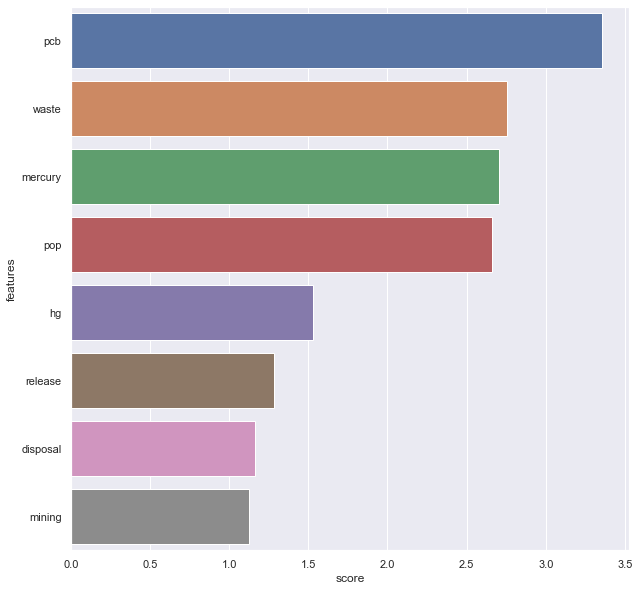

In [6]:
df_regressors = pd.DataFrame(columns = ["label", "features", "score"])


X_train, X_test, y_train, y_test = train_test_split(df['all_text_clean_spacy'],
                                                    df['waste_management'],
                                                    test_size = .3,
                                                    random_state = 1,
                                                    stratify = df['waste_management'].values,
                                                    shuffle = True)
print('train size:', len(X_train))
print('test size:', len(X_test))

assert len(set(y_train)) == len(set(y_test)), "Unequal splits with some labels missing"

'''extract features using tfidf vecorization:'''
vectorizer = TfidfVectorizer(ngram_range = (1,2),min_df = 0.01, max_df = 0.95)


vect = vectorizer.fit(X_train)
X_train = vect.transform(X_train)
X_test = vect.transform(X_test)

fnames = vect.get_feature_names()

clf = LogisticRegression(penalty='l2', solver = 'lbfgs', class_weight= 'balanced').fit(X_train, y_train)
print('')
print('Training accuracy:', clf.score(X_train, y_train).round(3))
print('Test accuracy:', clf.score(X_test, y_test).round(3))
y_hat = clf.predict(X_test)
print('f1 score:', f1_score(y_test, y_hat))
#top regressors 
#return top  regressors and convert to dataframe for visualisation:
df_lambda = tools.get_topwords(clf, vectorizer, n = 8, n_models = 1, show_idxmax = True)
keywords = df_lambda.Keywords.iloc[0]

for key in keywords:

    df_regressors = df_regressors.append({'label': 'persistent_organic_pollutants', "features":key}, ignore_index=True)
    df_regressors['features'] = df_regressors['features'].astype(str)
    df_regressors['features'] = df_regressors['features'].str.replace('(','')
    df_regressors['features'] = df_regressors['features'].str.replace(')','')
    df_regressors['features'] = df_regressors['features'].str.replace("'",'')               

from sklearn.metrics import classification_report
print(classification_report(y_test, y_hat))

df_regressors[['features','score']] = df_regressors['features'].str.split(',',expand=True)
df_regressors['score'] = df_regressors['score'].astype(float)    
plt.figure(figsize=(10,10))
sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = df_regressors)

In [7]:
import eli5
eli5.show_weights(clf, vec=vect, top=15,
                  target_names=y_test)

Weight?,Feature
+3.358,pcb
+2.757,waste
+2.706,mercury
+2.660,pop
+1.532,hg
+1.283,release
+1.163,disposal
+1.126,mining
+1.032,pesticide
+1.014,equipment


In [8]:
input_string = input()

he primary objective of the Philippines Green Climate Fund (GCF) Readiness Programme is to support the Government of Philippines in strengthening their national capacities to effectively and efficiently plan for, access, manage, deploy and monitor climate financing in particular through the GCF.  Specifically, the Programme will support capacitation and empowerment of the Philippines’ Climate Change Commission (CCC) as the National Designated Authority (NDA) for the GCF including relevant partner-government agencies.    The Programme will also target two important aspects of the GCF approach, access to funds and private sector engagement, through the selection of national/sub-national implementing entities for accreditation and the preparation of prioritized programmes/projects for submission to GCF


In [17]:
input_list = [input_string]
input_df = pd.DataFrame(input_list, columns =['all_text_clean_spacy'])
input_df['all_text_clean_spacy'] = input_df['all_text_clean_spacy'].apply(clean.spacy_clean)
clean_df = pd.Series(input_df['all_text_clean_spacy'])
clean_df

0    primary objective philippines green climate fu...
Name: all_text_clean_spacy, dtype: object

In [18]:
from eli5 import explain_weights, explain_prediction, show_prediction
from eli5.formatters import format_as_html, format_as_text, format_html_styles, fields
from IPython.core.display import display, HTML
show_html = lambda html: display(HTML(html))
show_html_expl = lambda expl, **kwargs: show_html(format_as_html(expl, include_styles=False, **kwargs))
show_html(format_html_styles())
from eli5.lime import TextExplainer

show_prediction(clf, 
                     vect.transform(clean_df), highlight_spaces = True,
                    top=10, feature_names=fnames, show_feature_values  = True)

In [15]:
cleandf = vect.transform(clean_df)

In [16]:
cleandf

<1x5057 sparse matrix of type '<class 'numpy.float64'>'
	with 0 stored elements in Compressed Sparse Row format>